In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
from AFLPy.AFLData_Client import load_data, upload_data, metadata

Data

In [5]:
shots = pd.read_csv(r"/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/data/predictions/shots_xs_catboost.csv")
shots['Year'] = shots['Match_ID'].apply(lambda x: int(x.split("_")[1]))
shots['Round'] = shots['Match_ID'].apply(lambda x: x.split("_")[2])
shots['Home'] = np.where(shots['Team'] == shots['Home_Team'], 1, 0)

In [6]:
shots.head()

,CD_Player_ID,Chain_Number,Team_Chain,Initial_State,Final_State,Period_Number,Period_Duration_Chain_Start,Description,Disposal,Shot_At_Goal,Behind_Detail,Order,Period_Duration,x,y,Home_Team,Away_Team,Home_Team_Direction_Q1,Venue_Width,Venue_Length,Player,Team,Match_ID,Player_ID,result,score,miss,behind,goal,predicted_result,behind_probas,goal_probas,miss_probas,xscore,angle,angle_degrees,chain_duration,description_0,description_1,description_2,description_3,distance,distance_log,distance_since_last_action,distance_squared,distance_to_goal_x,distance_to_middle_y,ground_kick,initial_state,period_duration_0,period_duration_1,period_duration_2,period_duration_3,set_shot,time_since_last_action,visible_behind_angle,visible_behind_angle_degrees,visible_goal_angle,visible_goal_angle_degrees,x_0,x_1,x_2,x_3,y_0,y_1,y_2,y_3,Year,Round,Home
0,CD_I990609,5,Brisbane,possGain,behind,1.0,50.0,Kick,ineffective,True,NaN,48.0,118.0,44.0,12.0,Sydney,Brisbane,right,141.0,160.0,Charlie Cameron,Brisbane,AFL_2024_F4_Sydney_Brisbane,charlie_cameron,behind,1,0,1,0,goal,0.326611,0.639306,0.034083,4.162447,0.321751,18.434949,68.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,37.947332,3.636199,8.246211,1440.0,36.0,12.0,0,possGain,118.0,76.0,74.0,72.0,1,42.0,0.512821,29.382451,0.161146,9.232981,44.0,52.0,51.0,34.0,12.0,10.0,10.0,55.0,2024,F4,0
1,CD_I294518,12,Brisbane,possGain,behind,1.0,270.0,Kick,ineffective,True,NaN,112.0,327.0,56.0,-33.0,Sydney,Brisbane,right,141.0,160.0,Joe Daniher,Brisbane,AFL_2024_F4_Sydney_Brisbane,joe_daniher,behind,1,0,1,0,goal,0.412004,0.453756,0.134240,3.134539,0.942000,53.972627,57.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,40.804412,3.708790,8.944272,1665.0,24.0,33.0,0,possGain,327.0,292.0,291.0,290.0,1,35.0,0.292973,16.786129,0.092823,5.318374,56.0,60.0,60.0,22.0,-33.0,-25.0,-25.0,-64.0,2024,F4,0
2,CD_I1006126,22,Sydney,throwIn,behind,1.0,550.0,Kick,ineffective,True,NaN,196.0,558.0,64.0,15.0,Sydney,Brisbane,right,141.0,160.0,James Rowbottom,Sydney,AFL_2024_F4_Sydney_Brisbane,james_rowbottom,behind,1,0,1,0,goal,0.389350,0.460539,0.150111,3.152583,0.753151,43.152390,8.0,Kick,Loose Ball Get,Gather,Contested Knock On,21.931712,3.087934,4.472136,481.0,16.0,15.0,0,throwIn,558.0,557.0,552.0,550.0,0,1.0,0.790042,45.266082,0.217521,12.463013,64.0,60.0,59.0,61.0,15.0,17.0,15.0,16.0,2024,F4,1
3,CD_I997100,24,Sydney,possGain,goal,1.0,576.0,Kick,effective,True,NaN,207.0,596.0,58.0,-21.0,Sydney,Brisbane,right,141.0,160.0,Will Hayward,Sydney,AFL_2024_F4_Sydney_Brisbane,will_hayward,goal,6,0,0,1,goal,0.350931,0.598992,0.050077,3.944881,0.762147,43.667780,20.0,Kick,Free Advantage,Free For,Kick Inside 50 Result,30.413813,3.414897,7.615773,925.0,22.0,21.0,0,possGain,596.0,595.0,594.0,589.0,1,1.0,0.507180,29.059288,0.153920,8.818975,58.0,55.0,62.0,62.0,-21.0,-28.0,-30.0,-30.0,2024,F4,1
4,CD_I996765,25,Sydney,centreBounce,goal,1.0,659.0,Kick,effective,True,NaN,218.0,677.0,51.0,28.0,Sydney,Brisbane,right,141.0,160.0,Tom Papley,Sydney,AFL_2024_F4_Sydney_Brisbane,tom_papley,goal,6,0,0,1,behind,0.467258,0.302938,0.229804,2.284884,0.767856,43.994914,18.0,Kick,Handball Received,Handball,Gather,40.311289,3.696632,10.000000,1625.0,29.0,28.0,0,centreBounce,677.0,675.0,673.0,673.0,0,2.0,0.363247,20.812538,0.114940,6.585559,51.0,45.0,48.0,50.0,28.0,20.0,19.0,19.0,2024,F4,1


In [26]:
def create_team_homeaway_summary(shots):
    
    shots['Opponent'] = np.where(shots['Team'] == shots['Away_Team'], shots['Home_Team'], shots['Away_Team'])
    
    shots_for = shots.groupby(['Team', 'Year', 'Home']).agg(
        score=('score', 'sum'),
        xscore=('xscore', 'sum'),
        num_shots=('score', 'size'),
        num_games=('Home', 'nunique')
    )
    
    shots_against = shots.groupby(['Opponent', 'Year', 'Home']).agg(
        concede=('score', 'sum'),
        xconcede=('xscore', 'sum'),
        num_shots_conceded=('score', 'size'),
    )
    shots_against = shots_against.rename_axis(index={'Opponent': 'Team'}) 
       
    team_match_summary = shots_for.merge(shots_against, left_index=True, right_index=True)
    team_match_summary['score_diff'] = team_match_summary['score'] - team_match_summary['concede']
    team_match_summary['xscore_diff'] = team_match_summary['xscore'] - team_match_summary['xconcede']
    team_match_summary['shot_diff'] = team_match_summary['num_shots'] - team_match_summary['num_shots_conceded']
    
    return team_match_summary.unstack().round(2)
    

In [30]:
team_homeaway_summary = create_team_homeaway_summary(shots)

In [39]:
team_homeaway_summary.sort_values(by = ('xscore', 1))

score         xscore          num_shots      num_games     \
Home                   0     1        0        1         0    1         0  1   
Team          Year                                                             
West Coast    2022   711   700   667.51   647.64       199  197         1  1   
              2023   737   656   740.33   683.62       233  219         1  1   
Hawthorn      2021   857   746   835.74   739.04       245  226         1  1   
Collingwood   2021   821   722   843.94   742.24       245  224         1  1   
Richmond      2024   726   725   767.50   764.30       236  237         1  1   
...                  ...   ...      ...      ...       ...  ...       ... ..   
Brisbane      2024  1340  1158  1312.30  1258.23       393  383         1  1   
Collingwood   2023   995  1321   914.88  1276.43       273  386         1  1   
Port Adelaide 2023   974  1340  1008.28  1331.64       314  410         1  1   
Geelong       2022   993  1426   991.82  1339.77       307  410         1  1   
Brisbane      2023   987  1433   955.06  1459.08       287  438         1  1   

                   concede       xconcede          num_shots_conceded       \
Home                     0     1        0        1                  0    1   
Team          Year                                                           
West Coast    2022    1253  1110  1194.14  1049.54                354  317   
              2023    1182  1473  1215.06  1387.62                362  402   
Hawthorn      2021     929   967   949.00   951.44                276  284   
Collingwood   2021     828   981   819.98   944.55                254  272   
Richmond      2024    1178  1144  1154.54  1137.26                350  332   
...                    ...   ...      ...      ...                ...  ...   
Brisbane      2024     928  1106   850.52  1107.39                263  345   
Collingwood   2023    1066   782  1101.04   841.07                340  262   
Port Adelaide 2023    1043  1069   953.72  1028.64                292  321   
Geelong       2022     831   814   820.82   798.05                244  244   
Brisbane      2023     916  1044   926.97   989.94                281  306   

                   score_diff      xscore_diff         shot_diff       
Home                        0    1           0       1         0    1  
Team          Year                                                     
West Coast    2022       -542 -410     -526.63 -401.90      -155 -120  
              2023       -445 -817     -474.73 -703.99      -129 -183  
Hawthorn      2021        -72 -221     -113.26 -212.40       -31  -58  
Collingwood   2021         -7 -259       23.96 -202.31        -9  -48  
Richmond      2024       -452 -419     -387.04 -372.96      -114  -95  
...                       ...  ...         ...     ...       ...  ...  
Brisbane      2024        412   52      461.78  150.84       130   38  
Collingwood   2023        -71  539     -186.16  435.37       -67  124  
Port Adelaide 2023        -69  271       54.56  303.00        22   89  
Geelong       2022        162  612      171.00  541.72        63  166  
Brisbane      2023         71  389       28.09  469.15         6  132  

[72 rows x 20 columns]

In [42]:
team_homeaway_summary['xscore'][1].mean() / team_homeaway_summary['xscore'][0].mean()

1.0760582447086633

In [43]:
team_homeaway_summary['score'][1].mean() / team_homeaway_summary['score'][0].mean()

1.0753478169416149

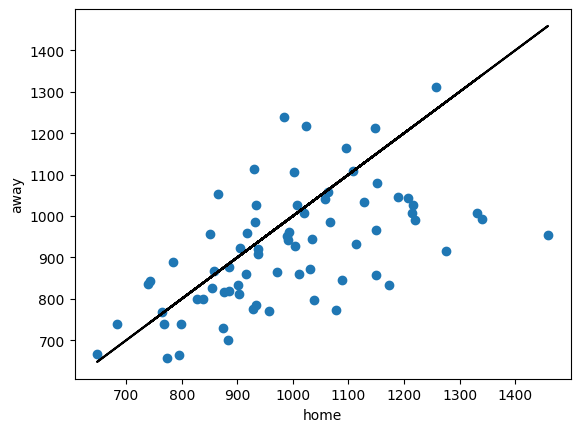

In [37]:
import matplotlib.pyplot as plt

plt.scatter(team_homeaway_summary['xscore'][1], team_homeaway_summary['xscore'][0])
plt.plot(team_homeaway_summary['xscore'][1], team_homeaway_summary['xscore'][1], c='k')
plt.xlabel('home')
plt.ylabel('away')
plt.show()